# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
import pickle
import requests
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
#!pip install census
#!pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# your code here

example_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015')

example_naep_query

## use requests to call the api
naep_resp = requests.get(example_naep_query)
naep_resp
print(type(naep_resp))

## get the json contents of the response 
## here, we're assuming valid response
naep_resp_j = naep_resp.json()
naep_resp_j

## with result, turn it into a dataframe
naep_resp_d = pd.DataFrame(naep_resp_j['result'])
naep_resp_d


'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

<Response [200]>

<class 'requests.models.Response'>


{'status': 200,
 'result': [{'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 275.020976636682,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 275.638637274477,
   'isStatDisplayable': 1,
   'errorFlag': 0}]}

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0


In [ ]:
## Question: What do scores look like between genders? 
## Math scores are roughly the same for students who identify as male or female in the 8th grade. However, the scores of female students 
## are slightly higher (by about 0.6 of a point on average). 

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
# your code here 

test_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019')

test_naep_query

## use requests to call the api
naep_resp_2 = requests.get(test_naep_query)
naep_resp_2
print(type(naep_resp_2))

## get the json contents of the response 
## here, we're assuming valid response
naep_resp_jz = naep_resp_2.json()
naep_resp_jz

## with result, turn it into a dataframe
naep_resp_dz = pd.DataFrame(naep_resp_jz['result'])
naep_resp_dz


'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

<Response [200]>

<class 'requests.models.Response'>


{'status': 200,
 'result': [{'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 277.167170641967,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 274.597823860242,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   's

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

<Figure size 2000x1000 with 0 Axes>

[]

Text(0.5, 1.0, 'Male and Female Math Scores By Odd Year')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Average Math Score')

(272.0, 277.29994776969266)

([<matplotlib.axis.XTick at 0x15b63d390>,
 [Text(2013, 0, '2013'),
  Text(2015, 0, '2015'),
  Text(2017, 0, '2017'),
  Text(2019, 0, '2019')])

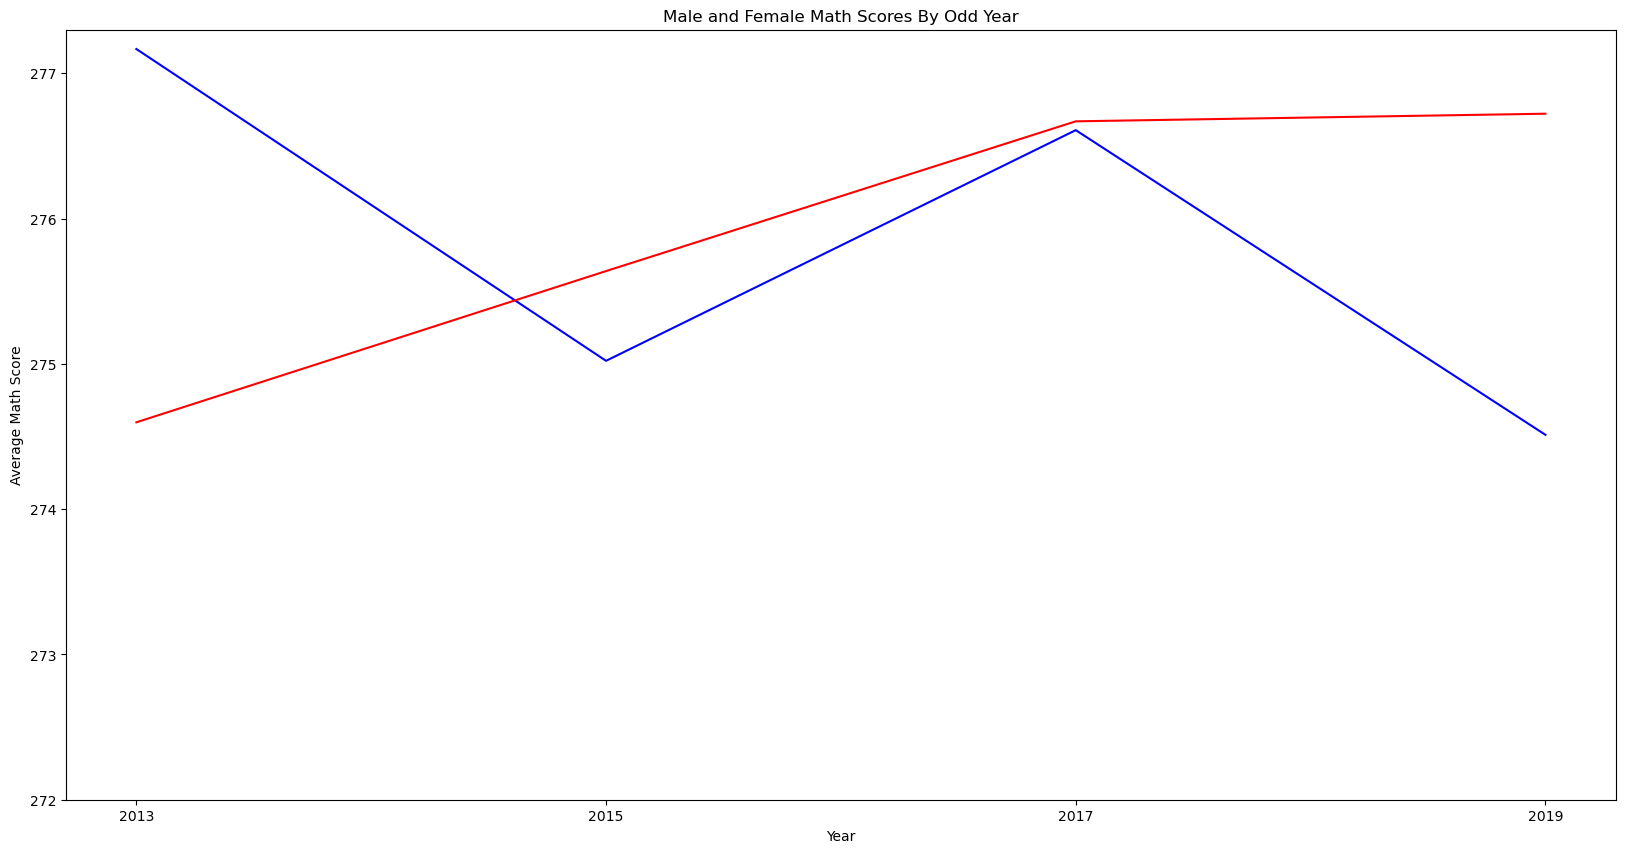

In [4]:
# your code here

# separating male and female data to prepare to plot 

male_data = naep_resp_dz[naep_resp_dz["varValueLabel"] == 'Male']

female_data = naep_resp_dz[naep_resp_dz["varValueLabel"] == 'Female']

# creating a line plot for year vs. male/female math score

plt.figure(figsize=(20, 10))
plt.plot(male_data['year'], male_data['value'], label = 'Male', color = 'blue')
plt.plot(female_data['year'], female_data['value'], label = 'Female', color = 'red')
plt.plot(color = 'red')
plt.title('Male and Female Math Scores By Odd Year')
plt.xlabel('Year')
plt.ylabel('Average Math Score')
plt.ylim(272)
plt.xticks([2013, 2015, 2017, 2019])
plt.show()


## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [20]:
# your code here 

year = [2013,2015,2017,2019]
place = ['CA']

def construct_naep_query(years: list,
                   baseurl = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1 = 'type=data&subject=mathematics&grade=8&',
                   query_part3 = 'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN'):
                       
    '''This function calls the NAEP API to get data on writing scores for the grade requested in 2011.
    
    Parameters:
        baseurl (str): default URL for NAEP or similar API
        query_part1 (str): first batch of arguments
        grades (list of int): what grades to get data on
        query_part3 (str): third batch of arguments
    Returns:
        DataFrame with the results'''
    
    dflist = []
    
    for year in years:
        naep_query = baseurl + query_part1  + query_part3 + ('&Year=' + str(year))
        naep_resp = requests.get(naep_query)
        
        #if "System.Exception" in naep_resp.text:
        #    print(f"NAEP results not found for grade {str(grade)}, please try with grade in range of 1-12")
        #else:
        try:
            naep_resp_df = pd.DataFrame(naep_resp.json()['result'])
            dflist.append(naep_resp_df)
        except Exception as e:
            print("Failed to get result from API for grade {} due to error:".format(str(grade)))
            print(e)
        
    combined_result_df = pd.concat(dflist)
    
    return(combined_result_df)


construct_naep_query(years = [2013,2015,2017,2019])


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
0,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
1,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
0,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
1,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [27]:
# Part I: writing a flexible function, executing the function, printing the dataframe 

def process_naep_query(years: list,
                   baseurl = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1 = 'type=data&subject=mathematics&grade=8&',
                   query_part3 = 'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN'):
    
    dflist = []
    
    for year in years:
        naep_query = baseurl + query_part1  + query_part3 + ('&Year=' + str(year))
        naep_resp = requests.get(naep_query)
        
        #if "System.Exception" in naep_resp.text:
        #    print(f"NAEP results not found for grade {str(grade)}, please try with grade in range of 1-12")
        #else:
        try:
            naep_resp_df = pd.DataFrame(naep_resp.json()['result'])
            dflist.append(naep_resp_df)
        except Exception as e:
            print("Data not found; check your query".format(str(year)))
            print(e)
        
    combined_result_df = pd.concat(dflist)
    
    return(combined_result_df)

process_naep_query(years = [2013,2015,2017,2019])


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
0,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
1,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
0,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
1,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


In [ ]:
# Part II: executing the function on a state that doesn't exist (ZZ)

def process_naep_query_2(years: list,
                   baseurl = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1 = 'type=data&subject=mathematics&grade=8&',
                   query_part3 = 'subscale=MRPCM&variable=GENDER&jurisdiction=ZZ&stattype=MN:MN'):
    
    dflist = []
    
    for year in years:
        naep_query = baseurl + query_part1  + query_part3 + ('&Year=' + str(year))
        naep_resp = requests.get(naep_query)
        
        #if "System.Exception" in naep_resp.text:
        #    print(f"NAEP results not found for grade {str(grade)}, please try with grade in range of 1-12")
        #else:
        try:
            naep_resp_df = pd.DataFrame(naep_resp.json()['result'])
            dflist.append(naep_resp_df)
        except Exception as e:
            print("Data not found; check your query".format(str(year)))
            print(e)
        
    combined_result_df = pd.concat(dflist)
    
    return(combined_result_df)

process_naep_query_2(years = [2013,2015,2017,2019])


# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [119]:
creds = load_creds("09_db_cred.yaml")

creds

{'practice_database': {'user': 'qss20',
  'password': 'xtPdDZHnxKMFSD5RyP',
  'port': 3306,
  'database': 'sentencing',
  'host': 'qss20-7570-db.c.dartmouth.edu'}}

In [120]:
## connect to the database
cnx = mysql.connector.connect(user=creds['practice_database']['user'], 
                            password=creds['practice_database']['password'],
                            port=creds['practice_database']['port'],
                            database= 'math_gencompare',
                            host = creds['practice_database']['host'])
cnx


## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [39]:
# your code here

q = """
SELECT 
    *
FROM math_gencompare
LIMIT 5
"""
pd.read_sql_query(q, cnx)


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/620174743.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,abbrev,FIPS,state,year,female,male
0,AK,2,Alaska,2013,281.388243030547,281.723376175464
1,AL,1,Alabama,2013,268.920111754346,269.457455785562
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923
4,CA,6,California,2013,274.597823860242,277.167170641967


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [40]:
# your code here

w = """
SELECT COUNT(*),
    COUNT(DISTINCT(state)) AS "Number of unique states",  
    COUNT(DISTINCT(year)) AS "Number of unique years"
FROM math_gencompare
"""

pd.read_sql_query(w, cnx)


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/850985788.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,COUNT(*),Number of unique states,Number of unique years
0,200,50,4


Interpreting Results

Question: How do you think the data is structured in terms of states and years (eg. long format where each state repeated; wide format)?

I think the data is structured in terms of long format because each row of the dataframe represents a unique combination of state, year, and score. 

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [41]:
## constructing the new variable—is_male_higher 

compare_math_q = """
SELECT *,
       CASE
         WHEN  male > female THEN 1
         ELSE 0
       END AS is_male_higher
FROM   math_gencompare 
"""

## reading in the results 

compare_charge_d = pd.read_sql_query(compare_math_q, cnx)

print(compare_charge_d.is_male_higher.head(), "Head of New Variable")
print()
print(compare_charge_d.is_male_higher.mean(axis = 0), "Mean of New Variable")
print()


0    1
1    1
2    0
3    1
4    1
Name: is_male_higher, dtype: int64 Head of New Variable

0.515 Mean of New Variable



/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/3367096455.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [42]:
## step 4
query_propdiv = """
SELECT 
    year,
    avg(is_div_bool) as prop_div
FROM  (
    SELECT 
        *,
        CASE 
            WHEN male > female THEN 1
            ELSE 0
        END is_div_bool
    FROM math_gencompare) AS d
GROUP BY year 
"""
prop_div = pd.read_sql_query(query_propdiv, cnx)
prop_div


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/2573034983.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,year,prop_div
0,2013,0.62
1,2015,0.56
2,2017,0.58
3,2019,0.30


B (Continued): Interpretation of Results

Based on the results of my analysis, I can conclude that on average, men score higher than women taking math exams in the years 2013, 2015, 2017, and 2019. The year where the number of states with men scoring higher than women was highest in 2013 (62% of the states reported men scoring higher than women on math exams), and the year where this was the lowest was 2019 when only 30% of states reported that men scored higher than women on math exams. 

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [121]:
# A. writing the query 

query_propdiv_2 = """
SELECT 
    state,
    avg(is_div_bool) as prop_div
FROM  (
    SELECT 
        *,
        CASE 
            WHEN male > female THEN 1
            ELSE 0
        END is_div_bool
    FROM math_gencompare) AS d
GROUP BY state
"""
prop_div_2 = pd.read_sql_query(query_propdiv_2, cnx)
prop_div_2


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/1097984995.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,state,prop_div
0,Alaska,0.75
1,Alabama,0.50
2,Arkansas,0.50
3,Arizona,0.75
4,California,0.25
5,Colorado,0.75
6,Connecticut,0.50
7,Delaware,0.50
8,Florida,0.75
9,Georgia,0.75


<Figure size 2000x1000 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'States with Male Math Scores Higher Than Female Math Scores (Percentage of 4-Year Window)')

Text(0.5, 0, 'State')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Pennsylvania'),
  Text(1, 0, 'Florida'),
  Text(2, 0, 'Wyoming'),
  Text(3, 0, 'Illinois'),
  Text(4, 0, 'Vermont'),
  Text(5, 0, 'West Virginia'),
  Text(6, 0, 'Nevada'),
  Text(7, 0, 'Maryland'),
  Text(8, 0, 'Arizona'),
  Text(9, 0, 'Connecticut'),
  Text(10, 0, 'Georgia'),
  Text(11, 0, 'Colorado'),
  Text(12, 0, 'New Hampshire'),
  Text(13, 0, 'Iowa'),
  Text(14, 0, 'Oregon'),
  Text(15, 0, 'Texas'),
  Text(16, 0, 'Nebraska'),
  Text(17, 0, 'South Carolina'),
  Text(18, 0, 'New Jersey'),
  Text(19, 0, 'North Carolina'),
  Text(20, 0, 'Montana'),
  Text(21, 0, 'California'),
  Text(22, 0, 'Kansas'),
  Text(23, 0, 'Kentucky'),
  Text(24, 0, 'Mississippi'),
  Text(25, 0, 'Ohio'),
  Te

Text(0, 0.5, 'Percentage')

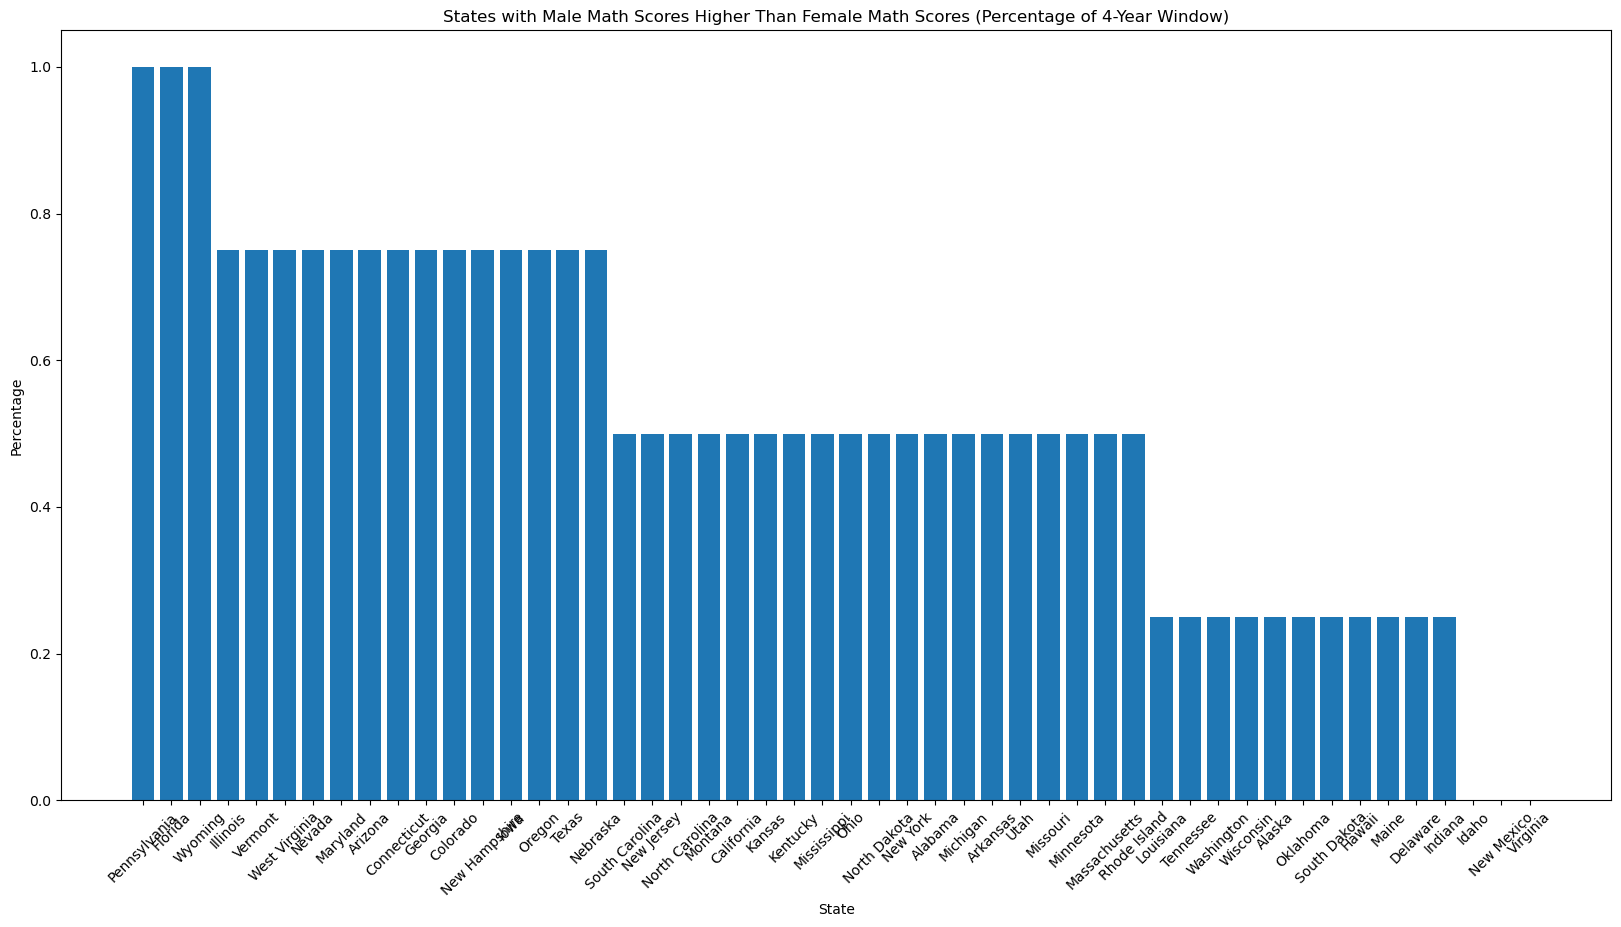

In [131]:
# B. plotting the results 

prop_div = prop_div_2["prop_div"]

# ordering the result from greatest to least 

sorted_indices = sorted(range(len(prop_div)), key = lambda i: prop_div[i], reverse=True)
sorted_states = [states[i] for i in sorted_indices]
sorted_differences = [prop_div[i] for i in sorted_indices]

plt.figure(figsize=(20, 10))
plt.bar(sorted_states, sorted_differences, data = prop_div_2)
plt.title('States with Male Math Scores Higher Than Female Math Scores (Percentage of 4-Year Window)')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.show()


## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [45]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]
list_suffrage


['Wyoming', 'Colorado', 'Utah', 'Idaho', 'Washington', 'California']

In [63]:

suffrage_states_str = ', '.join(["'{}'".format(state) for state in list_suffrage])

suffrage_states_str


"'Wyoming', 'Colorado', 'Utah', 'Idaho', 'Washington', 'California'"

In [76]:
## A. creating an indicator 

query_stuff = """
SELECT 
    state,
    CASE 
        WHEN state IN ({0}) THEN 1
        ELSE 0
    END AS is_early_voter
FROM math_gencompare AS d
""".format(suffrage_states_str)
suffrage = pd.read_sql_query(query_stuff, cnx)
suffrage


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/814829013.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,state,is_early_voter
0,Alaska,0
1,Alabama,0
2,Arkansas,0
3,Arizona,0
4,California,1
5,Colorado,1
6,Connecticut,0
7,Delaware,0
8,Florida,0
9,Georgia,0


In [93]:
## B. group by is_early_voter and year, find percentage of states where male higher than female 

query_with_percentage = """
SELECT 
    is_early_voter,
    year,
    (is_male_higher * 100.0) / total_states AS is_male_percent_higher
FROM (
    SELECT 
        is_early_voter,
        year,
        COUNT(*) AS total_states,
        SUM(CASE WHEN male > female THEN 1 ELSE 0 END) AS is_male_higher
    FROM (
        SELECT 
            state,
            CASE 
                WHEN state IN ({0}) THEN 1
                ELSE 0
            END AS is_early_voter,
            year,
            male,
            female
        FROM math_gencompare AS d
    ) AS subquery
    GROUP BY is_early_voter, year
) AS subquery_with_percentage;
""".format(suffrage_states_str)


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/1567582292.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,is_early_voter,year,is_male_percent_higher
0,0,2013,59.09091
1,1,2013,83.33333
2,0,2015,54.54545
3,1,2015,66.66667
4,0,2017,54.54545
5,1,2017,83.33333
6,0,2019,27.27273
7,1,2019,50.00000


In [94]:
# C. print the resulting dataframe and interpret

suffrage_2 = pd.read_sql_query(query_with_percentage, cnx)
suffrage_2


/var/folders/cw/mcjy6_9d6y5grbrjcwh5x8280000gn/T/ipykernel_13577/671160234.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,is_early_voter,year,is_male_percent_higher
0,0,2013,59.09091
1,1,2013,83.33333
2,0,2015,54.54545
3,1,2015,66.66667
4,0,2017,54.54545
5,1,2017,83.33333
6,0,2019,27.27273
7,1,2019,50.00000


Part B (Continued) Question: Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

No, early expansion of voting does not seem to be correlated with girls scoring better on math tests a century later. In states where women were given the right to vote early, they performed, by in large, much poorly than their male counterparts. Conversely, in states where women were not given an early right to vote, the percentage of men who scored higher than women is much lower. Further analyses would need to be conducted to determine the presence of a correlation between women given an early right to vote and performance on math exams more than a century later. At this time, I will not be so bold in my interpretation of the results as correlation does not equal causation. 

# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [97]:
## your code here

df = pd.read_pickle("acs_wmath.pkl")

df.head()
df.shape


,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

(50, 92)

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


<Figure size 2000x1000 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Difference in Male and Female Math Scores By State in 2013')

Text(0.5, 0, 'State')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Idaho'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'New Hampshire'),
  Text(3, 0, 'Delaware'),
  Text(4, 0, 'Arkansas'),
  Text(5, 0, 'Maine'),
  Text(6, 0, 'New Jersey'),
  Text(7, 0, 'Colorado'),
  Text(8, 0, 'Kentucky'),
  Text(9, 0, 'Ohio'),
  Text(10, 0, 'Kansas'),
  Text(11, 0, 'West Virginia'),
  Text(12, 0, 'New York'),
  Text(13, 0, 'Virginia'),
  Text(14, 0, 'Alaska'),
  Text(15, 0, 'Washington'),
  Text(16, 0, 'New Mexico'),
  Text(17, 0, 'Indiana'),
  Text(18, 0, 'Iowa'),
  Text(19, 0, 'Minnesota'),
  Text(20, 0, 'Nebraska'),
  Text(21, 0, 'Florida'),
  Text(22, 0, 'Illinois'),
  Text(23, 0, 'Missouri'),
  Text(24, 0, 'North Carolina'),
  Text(25, 0, 'South Carolina'),
  Text(26

Text(0, 0.5, 'Difference in Male and Female 2013 Math Scores')

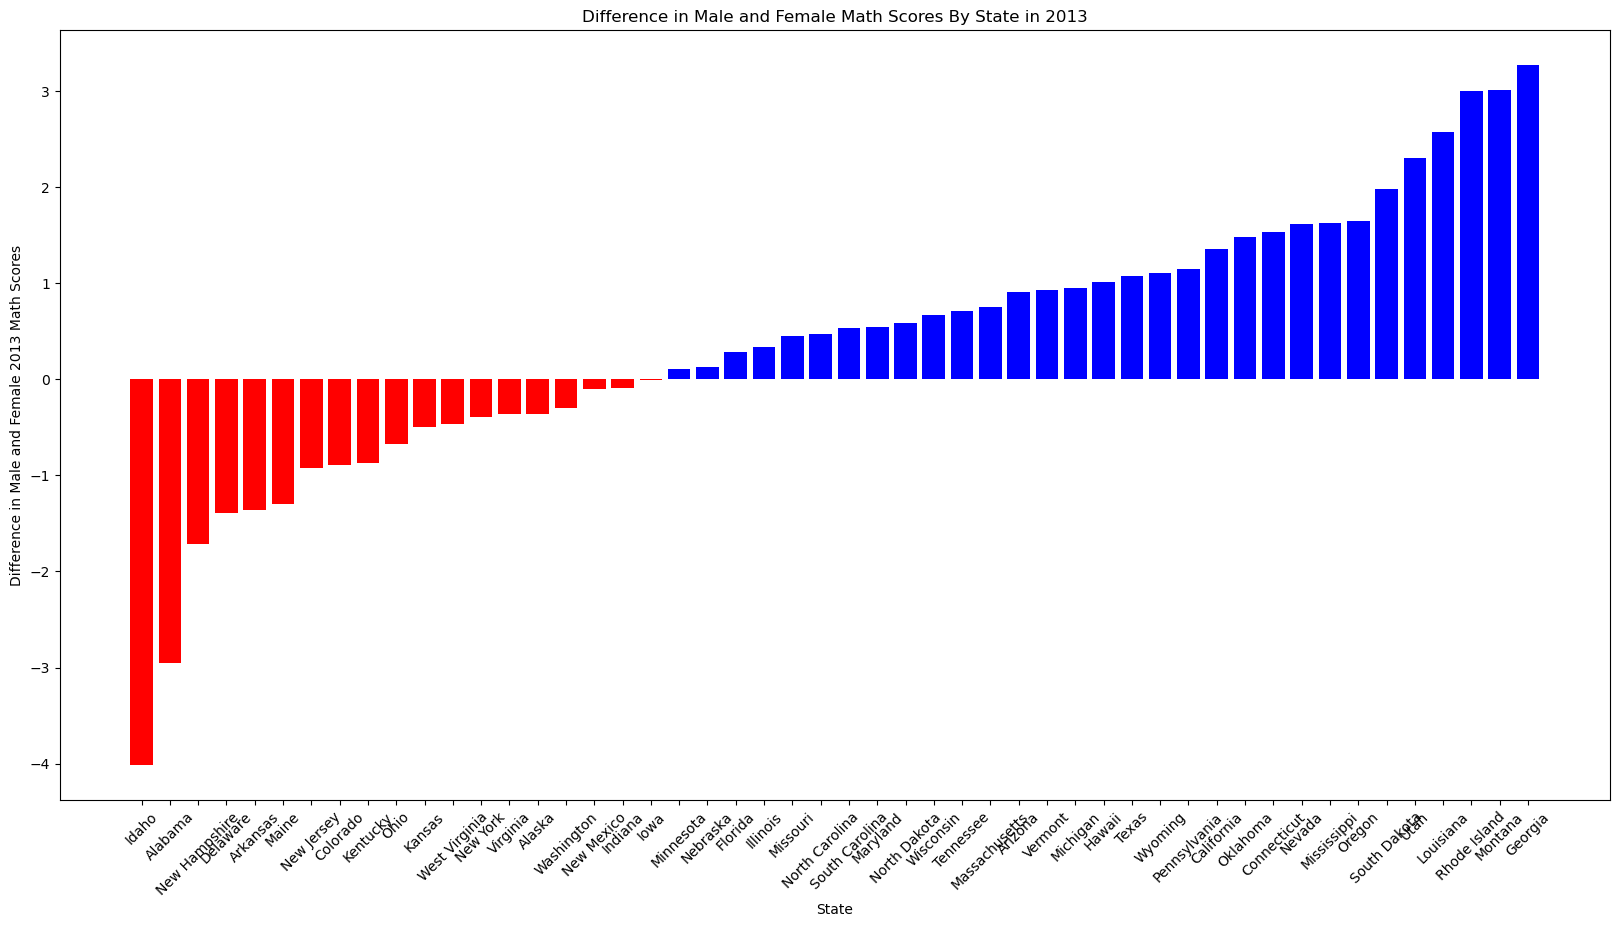

In [114]:
## your code here

difference = df["math_male_2013"] - df["math_female_2013"]

y_value = df["difference"]

# sorting the axises 

sorted_indices = sorted(range(len(difference)), key = lambda i: difference[i])
sorted_states = [states[i] for i in sorted_indices]
sorted_differences = [difference[i] for i in sorted_indices]

# making negative and positive scores different colors 

colors = ['green' if diff >= 0 else 'red' for diff in sorted_differences]

# plot for difference by state 
plt.figure(figsize=(20, 10))
plt.bar(sorted_states, sorted_differences, data = df, color = colors)
plt.title('Difference in Male and Female Math Scores By State in 2013')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Difference in Male and Female 2013 Math Scores')
plt.show()


Note: States with negative values are states where female students scored higher than male students. States with positive values are states
where male students scored higher than female students. 

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [68]:
## OFFICE HOURS QUESTION: Am I doing just 2013 performance? Or average performance overall? 
# just 2013 is fine 

avg_male_perform = df[["math_male_2013", 'math_male_2015', 'math_male_2017', 'math_male_2019']].mean().mean()

avg_female_perform = df[["math_female_2013", 'math_female_2015', 'math_female_2017', 'math_female_2019']].mean().mean()


282.47715177446753

In [ ]:
# A. constructing an indicator variable 

grouped = df.groupby('state')

def better_performance(group):
    group['better_perform'] = group['math_male_2013'] > group['math_female_2013']
    group['better_perform'] = group['better_perform'].astype(int)
    return group

df = grouped.apply(better_performance)

df.reset_index(drop=True, inplace=True)

df


<Figure size 2000x1000 with 0 Axes>

<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_male_2013'>

Text(0.5, 1.0, 'Average Male Math Score in 2013 vs. Median Household Income')

Text(0.5, 0, 'Median Household Income')

Text(0, 0.5, 'Male Math Score, 2013')

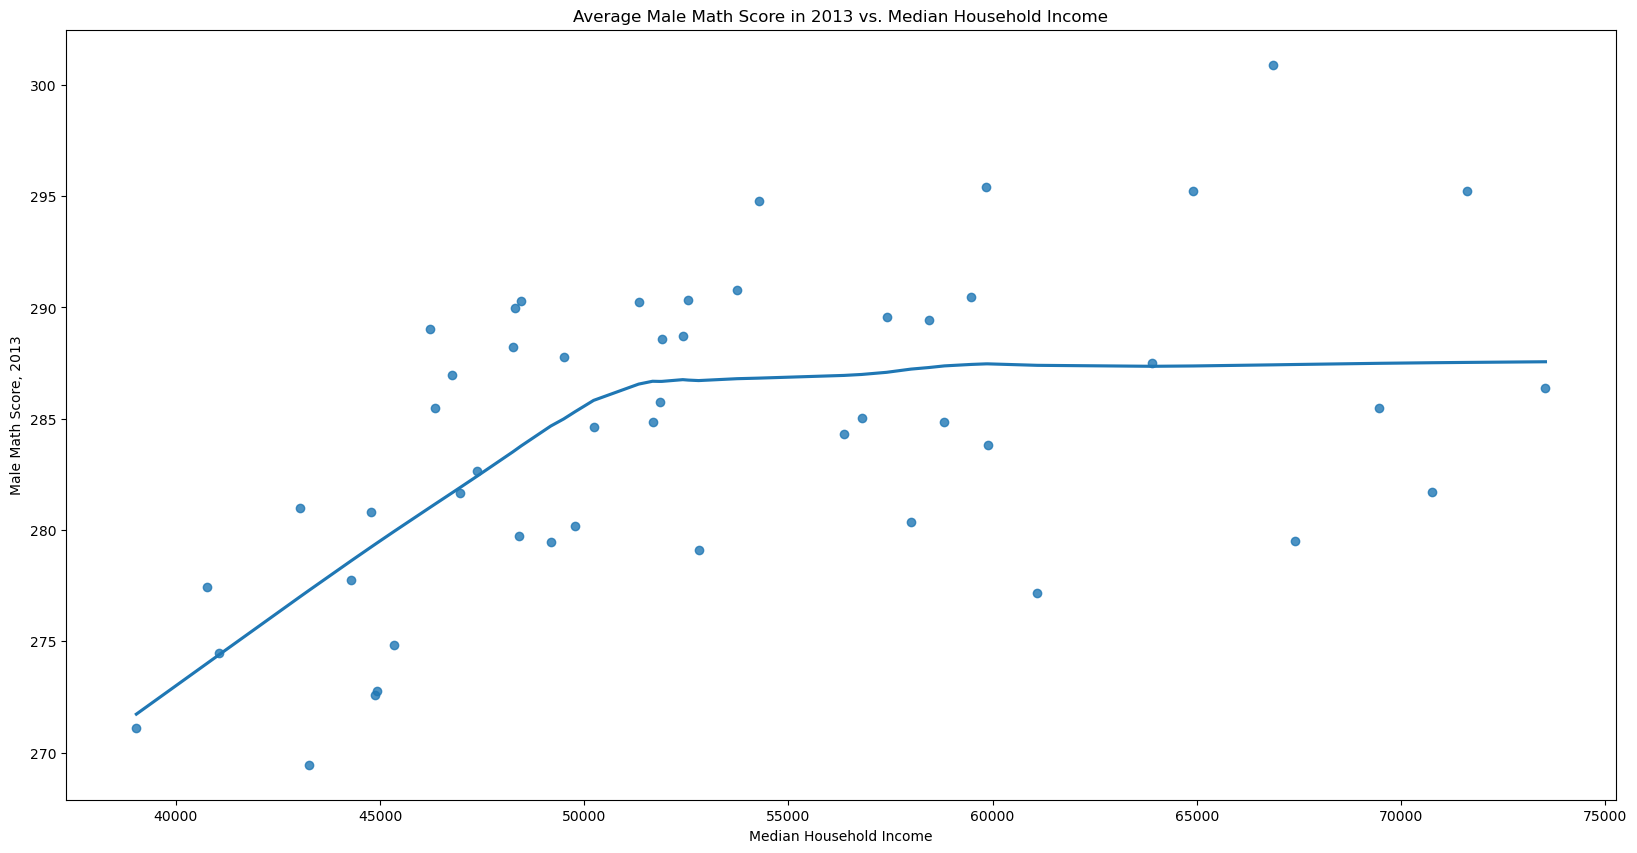

<Figure size 2000x1000 with 0 Axes>

<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_female_2013'>

Text(0.5, 1.0, 'Average Female Math Score in 2013 vs. Median Household Income')

Text(0.5, 0, 'Median Household Income')

Text(0, 0.5, 'Female Math Score, 2013')

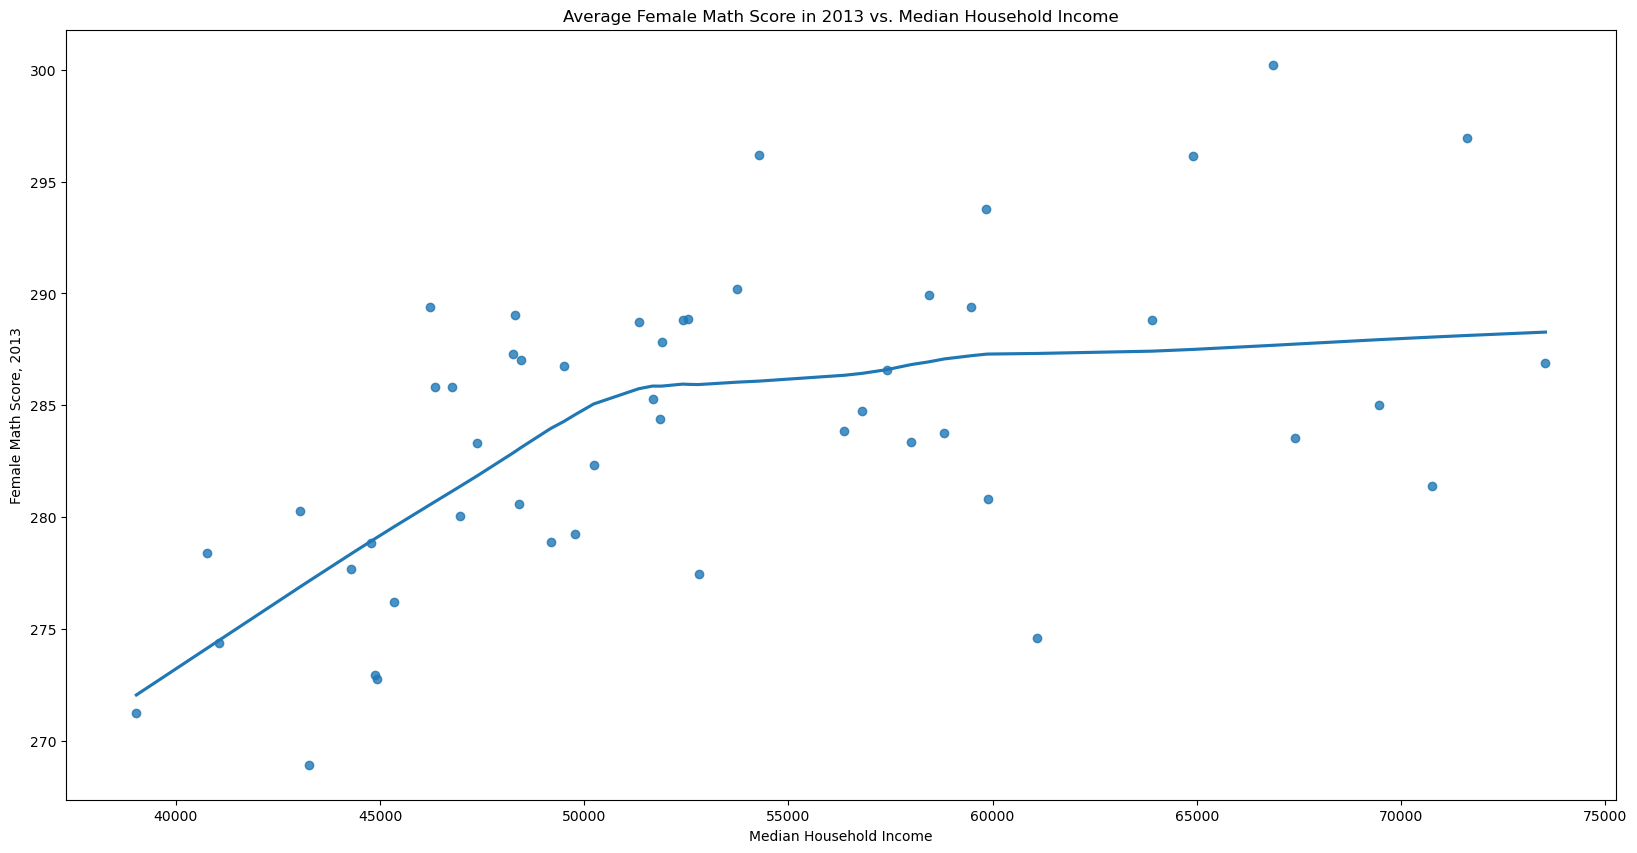

In [48]:
# B. creating a scatterplot 

# plot for math_male_2013
plt.figure(figsize=(20, 10))
sns.regplot(x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', y='math_male_2013', data = df, lowess = True)
plt.title('Average Male Math Score in 2013 vs. Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Male Math Score, 2013')
plt.show()

# plot for math_female_2013

plt.figure(figsize=(20, 10))
sns.regplot(x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', y='math_female_2013', data = df, ci = None, lowess = True)
plt.title('Average Female Math Score in 2013 vs. Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Female Math Score, 2013')
plt.show()


In [70]:
# C. using np.corrcoef

x = df["math_male_2013"]
y = df["acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars"]
z = df["math_female_2013"]
w = df["better_perform"]

male_cor = np.corrcoef(x, y)

female_cor = np.corrcoef(z, y)

indic_cor = np.corrcoef(w, y)


D. interpreting the correlations 

Question: In states with higher median household income (MHI), do...

1. boys tend to perform better than boys in states with lower MHI?

2. girls tend to perform better than girls in states with lower MHI?

3. boys tend to outperform girls more than they do in states with lower MHI?


## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [29]:
### A. your code here to load data

acs_math = pd.read_pickle("acs_wmath.pkl")

acs_math

,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

In [30]:
# B. your code here to construct binary indicators for male higher

acs_math["outcome_male_higher_female_2013"] = acs_math["math_male_2013"] > acs_math["math_female_2013"]

acs_math["outcome_male_higher_female_2015"] = acs_math["math_male_2015"] > acs_math["math_female_2015"]

acs_math["outcome_male_higher_female_2017"] = acs_math["math_male_2017"] > acs_math["math_female_2017"]

acs_math["outcome_male_higher_female_2019"] = acs_math["math_male_2019"] > acs_math["math_female_2019"]

acs_math


,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

In [80]:
# B. (Part II) removing any columns with the words math score in them 

acs_math = acs_math.drop(columns = ["math_female_2013", "math_female_2015", "math_female_2017", "math_female_2019",
                                   "math_male_2013", "math_male_2015", "math_male_2017", "math_male_2019"])


In [31]:
# C. Melt the data (acs_wmath) to long where instead of wide years, years are repeated within state

acs_wmath_long = pd.melt(acs_math, 
                          id_vars=['state'], 
                          value_vars=['outcome_male_higher_female_2013', 'outcome_male_higher_female_2015', 
                                      'outcome_male_higher_female_2017', 'outcome_male_higher_female_2019'])

acs_wmath_long['year'] = acs_wmath_long['variable'].str.split('_').str[-1]

acs_wmath_long.drop(columns=['variable'], inplace=True)

acs_wmath_long_repeated = pd.concat([acs_wmath_long] * 4, ignore_index=True)

acs_wmath_long.reset_index(drop=True, inplace=True)

acs_wmath_long.shape


(200, 3)

In [32]:
# D. your code here for train/test split

states = acs_wmath_long['state'].unique()

np.random.seed(42)  
np.random.shuffle(states)

train = states[:35]
test = states[35:]

train_set = acs_wmath_long[acs_wmath_long['state'].isin(train)]
test_set = acs_wmath_long[acs_wmath_long['state'].isin(test)]


train_set.nunique()

test_set.nunique()

state    35
value     2
year      4
dtype: int64

state    15
value     2
year      4
dtype: int64

In [ ]:
# E. your code here to normalize features and fit model

# normalizing features 

# fitting a model

# Estimate a decision tree classifier with max depth of 5
tree_classifier = DecisionTreeClassifier(max_depth=5)
tree_classifier.fit(X_train_scaled, y_train) 

In [ ]:
# F. your code here to interpret feature importances

In [ ]:
# G. your code here to evaluate model